# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [2]:
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

# Load Data

In [5]:
repo_fp = Path('./data')
tz_fp = repo_fp / 'Tanzania-Data'

In [6]:
tz_fp

PosixPath('data/Tanzania-Data')

## TAN Data

In [7]:
tz_sum = pd.read_csv(tz_fp / 'TAN_THYROID_summary.csv', index_col=0)
tz_sum

,Scan ID,Cytology no.,Diagnosis/Bethesda system,Bethesda actual,Histopathology,Present,Present (Manual)
0,TAN001,C-11-22,Malignant,5,Anaplastic carcinoma,1,exist
1,TAN002,C-20-22,Benign nodule,1,Simple Nodular Goitre,1,exist
2,TAN003,C-53-23,Benign nodule,1,Simple Nodular Goitre,1,exist
3,TAN004,C-36-23,Benign nodule,1,Simple Nodular Goitre,1,exist
4,TAN005,C-373-20,Benign nodule,1,Simple Nodular Goitre,1,exist
...,...,...,...,...,...,...,...
100,TAN101,C-076-23,Carcinoma,5,No biopsy,1,exist
101,TAN102,C-285-23,Goitre/thyroiditis,1,Cystic goitre,1,exist
102,TAN103,CP-01-23,Carcinoma,5,Anaplastic carcinoma,1,exist
103,TAN104,C-302-23,Colloid goitre,1,Colloid goitre,1,exist


In [8]:
tz_sum['Bethesda actual'].value_counts(dropna=False, normalize=False).sort_index()

Bethesda actual
0     1
1    78
2     2
3    11
4     1
5    12
Name: count, dtype: int64

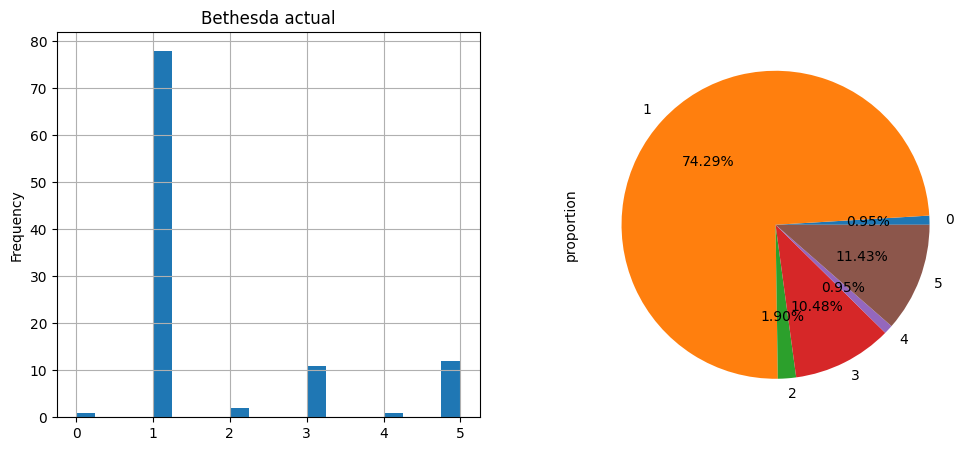

In [9]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
tz_sum['Bethesda actual'].plot(kind='hist', bins=20, title='Bethesda actual',ax=axs[0], grid=True)
tz_sum['Bethesda actual'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
def reload_or_create_classification_summary():
    filename = 'TAN_THYROID_classification_summary_bk.csv'
    filepath = tz_fp / filename
    if not filepath.exists():
        df = []
        for i, r in tz_sum.iterrows():
            id, label = r['Scan ID'], r['Bethesda actual']
            id_fp = tz_fp / id
            img_files = list(id_fp.iterdir())
            img_files = [i for i in img_files if (i.name.endswith('.jpg')) and (i.is_file())]
            for i in img_files:
                df.append(('TAN', id, str(i), label))
        df = pd.DataFrame(data=df, columns=['data', 'patient_id','img_path', 'label'])
        df.to_csv(filepath)
    else:
        df = pd.read_csv(filepath, index_col=0)
    return df


In [18]:
tz_img_label = reload_or_create_classification_summary()
tz_img_label['img_path'] = tz_img_label['img_path'].apply(lambda x: x.replace('/content/drive/MyDrive/Colab Notebooks/AI4Thyroid/', 'data/'))
tz_img_label

,img_path,label,dataset
0,data/Tanzania-Data/TAN001/IMG_20220623_141001.jpg,5,train
1,data/Tanzania-Data/TAN001/IMG_20220623_141241.jpg,5,train
2,data/Tanzania-Data/TAN001/IMG_20220623_140029.jpg,5,train
3,data/Tanzania-Data/TAN001/IMG_20220623_141314.jpg,5,train
4,data/Tanzania-Data/TAN001/IMG_20220623_134910.jpg,5,train
...,...,...,...
1302,data/Tanzania-Data/TAN105/IMG_230331130300006.jpg,3,test
1303,data/Tanzania-Data/TAN105/IMG_230331130436210.jpg,3,train
1304,data/Tanzania-Data/TAN105/IMG_230331130326705.jpg,3,val
1305,data/Tanzania-Data/TAN105/IMG_230331130239482.jpg,3,train


In [19]:
# Merge with patient-dataset to generate image-dataset
img_ds = tz_img_label
# img_ds.to_csv(repo_fp / 'image_dataset.csv')

In [20]:
img_ds

,img_path,label,dataset
0,data/Tanzania-Data/TAN001/IMG_20220623_141001.jpg,5,train
1,data/Tanzania-Data/TAN001/IMG_20220623_141241.jpg,5,train
2,data/Tanzania-Data/TAN001/IMG_20220623_140029.jpg,5,train
3,data/Tanzania-Data/TAN001/IMG_20220623_141314.jpg,5,train
4,data/Tanzania-Data/TAN001/IMG_20220623_134910.jpg,5,train
...,...,...,...
1302,data/Tanzania-Data/TAN105/IMG_230331130300006.jpg,3,test
1303,data/Tanzania-Data/TAN105/IMG_230331130436210.jpg,3,train
1304,data/Tanzania-Data/TAN105/IMG_230331130326705.jpg,3,val
1305,data/Tanzania-Data/TAN105/IMG_230331130239482.jpg,3,train


## Transform

In [21]:
plt.rcParams["savefig.bbox"] = 'tight'

In [22]:
img_path = img_ds.iloc[0]['img_path']
# img = read_image(img_path)
img = Image.open(img_path)

In [23]:
# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

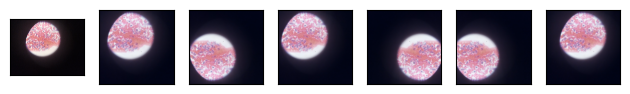

In [24]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [25]:
batch_size=16

# Dataset and DataLoader

In [26]:
# prompt: i need pytorch dataset that read from dataframe
class ThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        label = self.dataframe['label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [27]:
train_df = img_ds[img_ds['dataset']=='train'].reset_index(drop=True)
val_df = img_ds[img_ds['dataset']=='val'].reset_index(drop=True)
test_df = img_ds[img_ds['dataset']=='test'].reset_index(drop=True)

In [28]:
trainset = ThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [29]:
valset = ThyroidDataset(val_df, transform=test_transform)
valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

In [30]:
testset = ThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [31]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

data/Tanzania-Data/TAN022/IMG_221015113603573.jpg


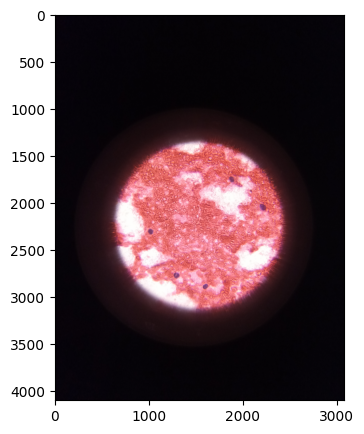

In [32]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['img_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


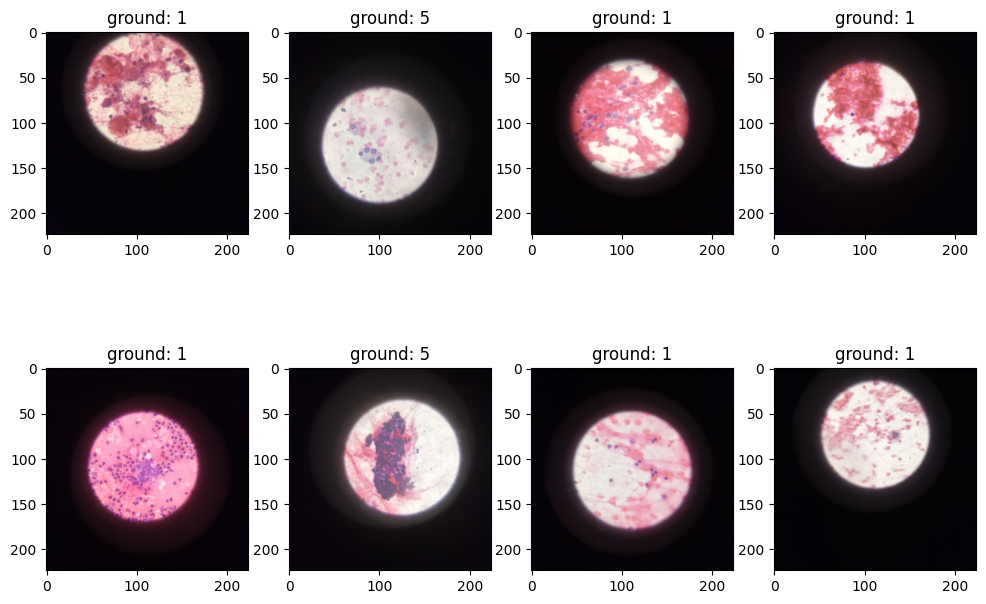

In [33]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [34]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [36]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/thyroid_tan')

2024-02-04 09:22:32.421397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 09:22:32.421575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 09:22:32.460472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 09:22:32.545054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 09:22:33.936240: W tensorflow/comp

# Load model

In [37]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(1280, train_df['label'].nunique())
model.to(device);

Loaded pretrained weights for efficientnet-b0


In [38]:
num_epochs = 50
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)

In [40]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [41]:
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    f1 = 0.0
    auc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
        # f1 += f1_score(output.argmax(dim=1), target)
        # auc += roc_auc_score(target, output[:, 1])
    loss /= len(testloader)
    acc /= len(testloader)
    # f1 /= len(testloader)
    # auc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    return acc

# If exist model, then evaluate before write new

In [42]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2,3,4,5]
    with torch.no_grad():
        preds = model(test_features.to(device))
        #print(preds)
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [43]:
# # reload model
# model_fp = repo_fp / 'efficientnet-b0-classification.pt'
# if model_fp.exists():
#     model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
#     best_val_acc = evaluate_dataset(model, valoader)
#     run_predict_testset()

In [44]:
best_val_acc

0.0

# Train model

In [45]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [46]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [47]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

In [48]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(valoader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(valoader)
    val_acc /= len(valoader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(valoader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(valoader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'efficientnet-b0-classification.pt')

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.9799 	Train Acc: 0.7132 	Val Loss: 1.8964 	Val Acc: 0.6879


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.7181 	Train Acc: 0.7512 	Val Loss: 1.1847 	Val Acc: 0.7112


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2 	Train Loss: 0.6510 	Train Acc: 0.7623 	Val Loss: 1.1528 	Val Acc: 0.6920


  0%|          | 0/51 [02:40<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.5396 	Train Acc: 0.8064 	Val Loss: 1.4619 	Val Acc: 0.4841


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 4 	Train Loss: 0.4861 	Train Acc: 0.8346 	Val Loss: 1.5973 	Val Acc: 0.5074


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 5 	Train Loss: 0.4808 	Train Acc: 0.8309 	Val Loss: 0.8341 	Val Acc: 0.7426


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 6 	Train Loss: 0.4038 	Train Acc: 0.8419 	Val Loss: 1.4784 	Val Acc: 0.6393


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 7 	Train Loss: 0.3579 	Train Acc: 0.8762 	Val Loss: 0.6834 	Val Acc: 0.7876


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 8 	Train Loss: 0.3051 	Train Acc: 0.8836 	Val Loss: 1.1163 	Val Acc: 0.7488


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 9 	Train Loss: 0.2427 	Train Acc: 0.9105 	Val Loss: 0.8387 	Val Acc: 0.8096


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 10 	Train Loss: 0.2382 	Train Acc: 0.9118 	Val Loss: 1.7122 	Val Acc: 0.4261


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 11 	Train Loss: 0.2356 	Train Acc: 0.9203 	Val Loss: 1.9938 	Val Acc: 0.7369


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 12 	Train Loss: 0.1277 	Train Acc: 0.9645 	Val Loss: 0.7240 	Val Acc: 0.8133


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 13 	Train Loss: 0.0805 	Train Acc: 0.9804 	Val Loss: 0.3700 	Val Acc: 0.8824


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 14 	Train Loss: 0.0882 	Train Acc: 0.9816 	Val Loss: 0.3075 	Val Acc: 0.8860


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 15 	Train Loss: 0.0782 	Train Acc: 0.9779 	Val Loss: 0.3179 	Val Acc: 0.8934


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 16 	Train Loss: 0.0707 	Train Acc: 0.9767 	Val Loss: 0.2967 	Val Acc: 0.9044


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 17 	Train Loss: 0.0602 	Train Acc: 0.9804 	Val Loss: 0.2896 	Val Acc: 0.9007


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 18 	Train Loss: 0.0550 	Train Acc: 0.9877 	Val Loss: 0.2914 	Val Acc: 0.8897


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 19 	Train Loss: 0.0445 	Train Acc: 0.9890 	Val Loss: 0.2968 	Val Acc: 0.9081


  0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc99e6cf100>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc99e6cf100>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 20 	Train Loss: 0.0329 	Train Acc: 0.9951 	Val Loss: 0.3169 	Val Acc: 0.8971


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
best_val_acc

0.9080882352941176

# Evaluate

In [50]:
evaluate_dataset(model, testloader)

  0%|          | 0/15 [00:00<?, ?it/s]

Test Loss: 0.0088 	Test Acc: 0.9167


0.9166666666666666